<a href="https://colab.research.google.com/github/AryanGupta0419/PytorchTutorial/blob/main/DLLAB7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler


In [6]:
df = pd.read_csv("creditcard.csv")

X = df.drop(columns=["Class"]).values
y = df["Class"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [7]:
class FraudDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.X[index], self.y[index]


In [8]:
train_dataset = FraudDataset(X_train_tensor, y_train_tensor)
test_dataset = FraudDataset(X_test_tensor, y_test_tensor)

class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
weights = class_weights[y_train]

sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
class FraudDetector(nn.Module):
    def __init__(self, input_dim):
        super(FraudDetector, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.fc(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FraudDetector(input_dim=X_train.shape[1]).to(device)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [10]:
num_epochs = 20
train_loss_list, train_acc_list, test_acc_list = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)

    train_acc = 100 * correct_train / total_train
    train_acc_list.append(train_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] -> Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")


Epoch [1/20] -> Train Loss: 0.0048, Train Acc: 77.99%
Epoch [2/20] -> Train Loss: 0.0013, Train Acc: 93.84%
Epoch [3/20] -> Train Loss: 0.0011, Train Acc: 96.02%
Epoch [4/20] -> Train Loss: 0.0006, Train Acc: 97.13%
Epoch [5/20] -> Train Loss: 0.0005, Train Acc: 98.06%
Epoch [6/20] -> Train Loss: 0.0007, Train Acc: 98.08%
Epoch [7/20] -> Train Loss: 0.0004, Train Acc: 98.65%
Epoch [8/20] -> Train Loss: 0.0004, Train Acc: 98.76%
Epoch [9/20] -> Train Loss: 0.0004, Train Acc: 98.69%
Epoch [10/20] -> Train Loss: 0.0005, Train Acc: 98.83%
Epoch [11/20] -> Train Loss: 0.0007, Train Acc: 98.82%
Epoch [12/20] -> Train Loss: 0.0004, Train Acc: 98.94%
Epoch [13/20] -> Train Loss: 0.0006, Train Acc: 98.66%
Epoch [14/20] -> Train Loss: 0.0004, Train Acc: 98.78%
Epoch [15/20] -> Train Loss: 0.0004, Train Acc: 98.94%
Epoch [16/20] -> Train Loss: 0.0005, Train Acc: 98.81%
Epoch [17/20] -> Train Loss: 0.0003, Train Acc: 99.36%
Epoch [18/20] -> Train Loss: 0.0005, Train Acc: 98.96%
Epoch [19/20] -> Tr

In [11]:
model.eval()
y_true, y_pred, y_probs = [], [], []
correct_test, total_test = 0, 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of class 1 (Fraud)

        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

        total_test += y_batch.size(0)
        correct_test += (predicted == y_batch).sum().item()

test_acc = 100 * correct_test / total_test
test_acc_list.append(test_acc)
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 99.36%



Classification Report:
               precision    recall  f1-score   support

           0     0.9998    0.9938    0.9968     56864
           1     0.1968    0.8776    0.3215        98

    accuracy                         0.9936     56962
   macro avg     0.5983    0.9357    0.6591     56962
weighted avg     0.9984    0.9936    0.9956     56962



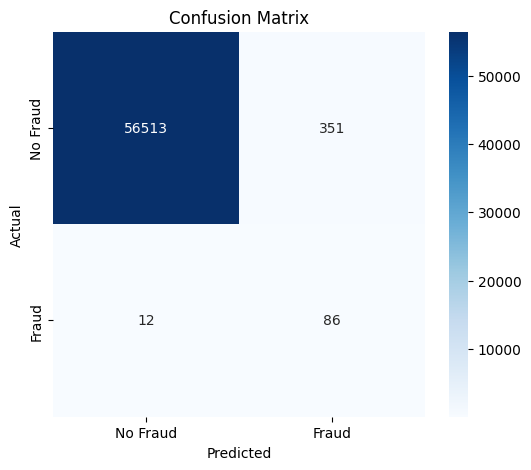

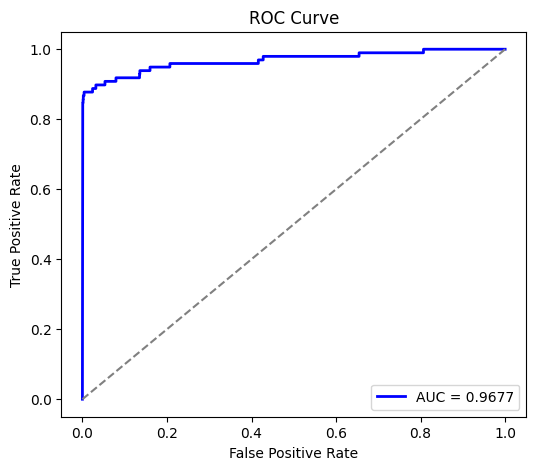

In [12]:
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()